# Pulse Window Cut Definitions
## Import the libraries

In [1]:
import sys,os
import time 
import h5py

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

sys.path.append('/home/nexus-admin/NEXUS_RF/BackendTools')
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
import TimestreamHelperFunctions as Thf

## Gather the files

In [2]:
datapath = '/data/USRP_Laser_Data'
series   = "20230215_101743"

sum_file, dly_file, vna_file, nse_files, led_files = Thf.GetFiles(series, 
                                                        base_path=datapath,
                                                        sep_noise_laser=True,
                                                        verbose=False)

In [3]:
for f in nse_files:
    print(f)

/data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_11.h5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_14.h5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_2.h5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_5.h5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_8.h5


## Load the summary file

In [4]:
md, charFs, charZs = Thf.UnpackSummary(sum_file, verbose=False)
rf_power = md['power'] + md['tx_gain']
print("RF Power at USRP:", rf_power, "dBm")

for i in np.arange(len(nse_files)):
    print(nse_files[i].split("/")[-1].split(".")[0],charZs[i])
    print(charFs[i])

RF Power at USRP: -16 dBm
USRP_Noise_20230215_101743_delta0 [0.13392927+0.06659739j 0.13341133+0.07298083j 0.13270856+0.08030111j]
[4241.97901  4241.979857 4241.980704]
USRP_Noise_20230215_101743_delta0_11 [0.13429799+0.06697518j 0.13330332+0.07371326j 0.13196758+0.08167826j]
[4241.97901  4241.979857 4241.980704]
USRP_Noise_20230215_101743_delta0_14 [0.1346246 +0.06696931j 0.13358658+0.07367139j 0.13323895+0.08044304j]
[4241.97901  4241.979857 4241.980704]
USRP_Noise_20230215_101743_delta0_2 [0.13432564+0.06824386j 0.13380083+0.07443833j 0.1335927 +0.08105339j]
[4241.97901  4241.979857 4241.980704]
USRP_Noise_20230215_101743_delta0_5 [0.13312294+0.06672976j 0.13253673+0.07319285j 0.13192562+0.0804867j ]
[4241.97901  4241.979857 4241.980704]
USRP_Noise_20230215_101743_delta0_8 [0.13273744+0.06659688j 0.13206492+0.07325275j 0.13212356+0.07980579j]
[4241.97901  4241.979857 4241.980704]


/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


### LED voltages
Determine how many LED timestream files there are and get an array of the LED voltages used for each.

In [5]:
voltages = np.array([])

for k in md.keys():
    if 'LaserScan_' in k:
        voltages = np.append(voltages, float(int(1000*md[k]['LEDvoltage'][0]))/1000.)

n_volts  = len(voltages)
n_runs   = len(led_files)
print(n_volts, n_runs, "<-- These should be the same")
print("Vmin = ",np.min(voltages), "V")
print("Vmax = ",np.max(voltages), "V")
# print("Vstep = ",int((voltages[1]-voltages[0])*1e3), "mV")

17 17 <-- These should be the same
Vmin =  2.0 V
Vmax =  6.0 V


### Define some PSD parameters

In [6]:
## PSD hi and lo frequency limits
chunk_up_to      = 1e1
decimate_down_to = 5e4

## Transient period at front of timestream
blank_fraction = 0.1

### Extract the pulse profile
This assumes that each laser timestream is acquired with the same AWG settings.

In [7]:
## Extract the pulse settings, assuming they're all the same
for k in md.keys():
    if 'LaserScan_' in k:
        LED_rate_Hz = md[k]['LEDfreqHz'][0]
        lapse_sec   = md[k]['duration'][0]
        pulse_w     = md[k]['LEDpulseus'][0]
        delay_ms    = md[k]['delayms'][0]
        break
print("Pulse f: ",LED_rate_Hz,"Hz")
print("Pls wdth:",pulse_w,"us")
print("Duration:",lapse_sec,"sec")
print("P  delay:",delay_ms,"ms")

total_pulses = LED_rate_Hz*lapse_sec

time_btw_pulse = 1./LED_rate_Hz
num_pulses = int(total_pulses * (1 - blank_fraction))
print("Total pulse windows:",total_pulses)
print("Time between pulse arrival:",time_btw_pulse,"sec")
print("Number of windows to look at:",num_pulses)

Pulse f:  5.0 Hz
Pls wdth: 2.0 us
Duration: 200.0 sec
P  delay: 5.0 ms
Total pulse windows: 1000.0
Time between pulse arrival: 0.2 sec
Number of windows to look at: 900


## Pick which files to scan

In [8]:
files_to_skip = 0 ## How many to skip at beginning
files_to_trim = 0 ## How many to cut off at end

LED_files = led_files[files_to_skip:n_runs-files_to_trim]
Voltages  = voltages[files_to_skip:n_runs-files_to_trim]

LED_files = LED_files#[::2][:-2]
Voltages  = Voltages#[::2][:-2]

# LED_files = LED_files[:-7]
# Voltages  = Voltages[:-7]

# LED_files = LED_files[Voltages != 5.00]
# Voltages  = Voltages[ Voltages != 5.00]

# LED_files = LED_files[Voltages != 5.00]
# Voltages  = Voltages[ Voltages != 5.00]

for i in np.arange(len(LED_files)):
    print(LED_files[i],":",Voltages[i])

PHASE = True

/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743.h5 : 2.0
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.250V_20230215_101743.h5 : 2.25
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.500V_20230215_101743.h5 : 2.5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.750V_20230215_101743.h5 : 2.75
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.000V_20230215_101743.h5 : 3.0
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.250V_20230215_101743.h5 : 3.25
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.500V_20230215_101743.h5 : 3.5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.750V_20230215_101743.h5 : 3.75
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_4.000V_20230215_101743.h5 : 4.0
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_4.250V_20230215_101743.h5 : 4.25
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_4.500V_20230215

## Pulse window plotting and removal of bad windows

In [9]:
## Window selection
pretrig_seconds = (delay_ms-0.250)*1e-3
postpls_seconds = (delay_ms+2.500)*1e-3
peak_area_nsamp = 4
# plspeak_secmax  = (delay_ms+0.250)*1e-3
# plspeak_secmin  = (delay_ms-0.100)*1e-3
p1 =  5 # 25 #  
p2 = 90 # 75 # 

In [10]:
## Create a container for RQs from each window

## Empty dictionary, each entry of which will be a Pandas DataFrame with a key given by the file name
pulse_RQs = {} 

## List of RQ names that will be used as keys in the dictionaries that are the entries in the above dict
RQ_names = [
    "pre_trig_bl_mean",
    "pre_trig_bl_sdev",
    "post_pls_bl_mean",
    "post_pls_bl_sdev",
    "full_win_max",
    "full_win_maxsamp",
    "pre_pls_max",
    "post_pls_max",
    "peak_pls_max",
]

In [11]:
show_plots = False

## Loop over every file (LED voltage)
for pulse_file in LED_files:
    print('===================')
    print('plotting pulse file:',pulse_file)
    print('using VNA file:     ',vna_file)
    print('using noise file:   ',nse_files[0])
    noise_file = nse_files[0]
    
    ## Create plots to store waveforms
    ## ========================================================================
    if show_plots:
        fi0 = plt.figure(pulse_file+"_a")
        ax0 = fi0.gca()
        ax0.set_xlabel("Time [ms]")
        ax0.set_ylabel(r"$\log_{10}|S_{21}|$")
        if PHASE:
            ax0.set_ylabel(r"$\arg (S_{21})$")
        ax0.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))

        fi1 = plt.figure(pulse_file+"_b")
        ax1 = fi1.gca()
        ax1.set_xlabel(r"$\Re(S_{21})$")
        ax1.set_ylabel(r"$\Im(S_{21})$")
        ax1.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
        
        fiq = plt.figure(pulse_file+"_q")
        axq = fiq.gca()
        axq.set_xlabel("Time [ms]")
        axq.set_ylabel(r"$\log_{10}|S_{21}|$")
        if PHASE:
            axq.set_ylabel(r"$\arg (S_{21})$")
        axq.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
    ## ========================================================================

    ## Determine how much additional decimation to apply
    pulse_noise, pulse_info = PUf.unavg_noi(pulse_file)
    pulse_fs = 1./pulse_info['sampling period']
    pulse_cleaning_decimation = 4 # int(pulse_fs/decimate_down_to)

    ## Get the decimated timestream and frequency step
    pulse_noise = Prf.average_decimate(pulse_noise,pulse_cleaning_decimation)
    pulse_fs   /= pulse_cleaning_decimation
    
    ## Create a new array of of frequency space with the applied decimation
    sampling_rate = pulse_fs
    samples_per_pulse = int(time_btw_pulse*sampling_rate)
    N = int(samples_per_pulse)-1
    T = N/sampling_rate
    t,f = Prf.build_t_and_f(N,sampling_rate)
    
    ## Define the regions where pulses exist
    ## =====================================
    
    ## This defines where (in # of pulse windows) to start looking for pulse windows
    pulse_start = int(total_pulses * blank_fraction)
    
    ## Define some times of interest in units of samples
    pretrig = int(pretrig_seconds * sampling_rate) ## Region before pulse rising edge / trigger
    pstpuls = int(postpls_seconds * sampling_rate) ## Region after pulse has returned to baseline
    plstrig = int(delay_ms*1e-3   * sampling_rate) ## Sample at the trigger time
    
    ## Average baseline of the three timestreams across all pulse windows
    noise_averages = 0
    
    ## Create empty arrays to store values which we will use to perform quality cuts
    ## These will have an entry for each pulse window
    bl_means_pre = [] ; bl_sdevs_pre = [] 
    bl_means_pst = [] ; bl_sdevs_pst = [] 
    pls_maxs = [] ; pls_amaxs = []
    pre_maxs = [] ; pst_maxs  = [] ; pk_maxs = []
    
    ## Start the loop over pulse windows
    k=0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        
        ## Define the sample index where this pulse window ends
        pulse_i_end = int((pulse_i+1)*samples_per_pulse)
        
        ## Define the edges of the pulse window
        pulse_idx_start = pulse_i_end - N
        pulse_idx_end   = pulse_i_end
        
        ## Grab the timestreams in the various regions
        full_pulse_chunk  = pulse_noise[pulse_idx_start:pulse_idx_end,:]
        pre_trigger_chunk = pulse_noise[pulse_idx_start:pulse_idx_start+pretrig,:]
        post_pulse_chunk  = pulse_noise[pulse_idx_start+pstpuls:pulse_idx_end,:]
        peak_pulse_chunk  = pulse_noise[pulse_idx_start+plstrig-peak_area_nsamp:pulse_idx_start+plstrig+peak_area_nsamp]
        
        ## Determine the two quadratures we care about
        phase_pre  = np.angle(pre_trigger_chunk[:,0])
        logmag_pre = np.log10(abs(pre_trigger_chunk[:,0]))
        
        phase_pst  = np.angle(post_pulse_chunk[:,0])
        logmag_pst = np.log10(abs(post_pulse_chunk[:,0]))
        
        phase_fll  = np.angle(full_pulse_chunk[:,0])
        logmag_fll = np.log10(abs(full_pulse_chunk[:,0]))
        
        phase_pk   = np.angle(peak_pulse_chunk[:,0])
        logmag_pk  = np.log10(abs(peak_pulse_chunk[:,0]))
        
        ## Calculate the RQs for this pulse window
        if PHASE: 
            m0 = np.mean( phase_pre ) ; s0 = np.std( phase_pre ) ## Find mean, sdev of pre-trigger window
            m1 = np.mean( phase_pst ) ; s1 = np.std( phase_pst ) ## Find mean, sdev of post-pulse window
            x  = np.max ( phase_fll )   ## Find maximum pulse height in full window
            x0 = np.max ( phase_pre )   ## Find maximum pulse height in pre-pulse window
            x1 = np.max ( phase_pst )   ## Find maximum pulse height in post-pulse window
            p  = np.max ( phase_pk )    ## Find maximum pulse height in a window right around the trigger
            a  = np.argmax( phase_fll ) ## Find the sample with the maximum height in the full window
        else:
            m0 = np.mean( logmag_pre ) ; s0 = np.std( logmag_pre )
            m1 = np.mean( logmag_pst ) ; s1 = np.std( logmag_pst )
            x  = np.max ( logmag_fll )
            x0 = np.max ( phase_pre )
            x1 = np.max ( logmag_pst )
            p  = np.max ( logmag_pk )
            a  = np.argmax( logmag_fll )
            
        ## Append our RQs to our lists
        bl_means_pre.append(m0) ; bl_means_pst.append(m1)
        bl_sdevs_pre.append(s0) ; bl_sdevs_pst.append(s1)
        pls_maxs.append(x) ; pls_amaxs.append(a)
        pre_maxs.append(x0); pst_maxs.append(x1); pk_maxs.append(p)
        
        ## Keep a running average of the baseline noise in pre-trigger region across all pulse regions
        noise_averages += m1    
        
        ## Plot the full pulse window against time
        if show_plots:
            if PHASE:
                ax0.plot(t*1e3,phase_fll,alpha=0.25)
#                 ax0.plot(t[:len(phase_pre)]*1e3,phase_pre,alpha=0.25)
#                 ax0.plot(t[-len(phase_pst):]*1e3,phase_pst,alpha=0.25)
            else:
                ax0.plot(t*1e3,logmag_fll,alpha=0.25)
#                 ax0.plot(t[:len(logmag_pre)]*1e3,logmag_pre,alpha=0.25)
#                 ax0.plot(t[-len(logmag_pst):]*1e3,logmag_pst,alpha=0.25)
            ax1.scatter(full_pulse_chunk[:,0].real,full_pulse_chunk[:,0].imag,alpha=0.25)
        
        ## Increment the good pulse counter
        k += 1
    
    ## Average the baseline mean over every pulse window
    noise_averages /= k
    
    ## Start the RQ arrays to our dictionary for this filename
    pulse_RQs[pulse_file] = {
        RQ_names[0]: bl_means_pre,
        RQ_names[1]: bl_sdevs_pre,
        RQ_names[2]: bl_means_pst,
        RQ_names[3]: bl_sdevs_pst,
        RQ_names[4]: pls_maxs,
        RQ_names[5]: pls_amaxs,
        RQ_names[6]: pre_maxs,
        RQ_names[7]: pst_maxs,
        RQ_names[8]: pk_maxs,
    }
         
    ## Draw some lines to mark the pulse window regions
    if show_plots:
        ax0.axhline(y=noise_averages,color="k",ls='--')
        ax0.axhline(y=noise_averages+1.0*np.mean(bl_sdevs_pst),color="k",ls=':')
        ax0.axvline(x=pretrig_seconds*1e3,color="k",ls=':')
        ax0.axvline(x=postpls_seconds*1e3,color="r",ls=':')
#         ax0.axvline(x=plspeak_secmax*1e3,color="g",ls=':')
#         ax0.axvline(x=plspeak_secmin*1e3,color="g",ls=':')
        ax0.axvline(x=delay_ms,color="b",ls="--")
#     ax0.set_xlim([0.0,10.0])
    
    ## Create plots/histograms that inform our cuts
    ## ========================================================================
    if show_plots:
        fi2 = plt.figure(pulse_file+"_c")
        ax2 = fi2.gca()
        ax2.hist(bl_means_pre, 
             bins=np.arange(
                 start = np.min( bl_means_pre ) ,
                 stop  = np.max( bl_means_pre ) + 5e-4,
                 step  = 5e-4))
        ax2.axvline(x=np.percentile(bl_means_pre,p1), color="k",ls='--')
        ax2.axvline(x=np.percentile(bl_means_pre,p2), color="k",ls='--')
        if PHASE:
            ax2.set_xlabel(r"Pre-trigger BL mean $\arg(S_{21})$")
        else:
            ax2.set_xlabel(r"Pre-trigger BL mean $\log_{10}(|S_{21}|)$")
        ax2.set_ylabel("Occurences")
        ax2.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))

        fi3 = plt.figure(pulse_file+"_d")
        ax3 = fi3.gca()
        ax3.hist(bl_sdevs_pre, 
             bins=np.arange(
                 start = np.min( bl_sdevs_pre ) ,
                 stop  = np.max( bl_sdevs_pre ) + 1e-5,
                 step  = 1e-5))
        ax3.axvline(x=np.percentile(bl_sdevs_pre,p1), color="k",ls='--')
        ax3.axvline(x=np.percentile(bl_sdevs_pre,p2), color="k",ls='--')
        if PHASE:
            ax3.set_xlabel(r"Pre-trigger BL sdev $\arg(S_{21})$")
        else:
            ax3.set_xlabel(r"Pre-trigger BL sdev $\log_{10}(|S_{21}|)$")
        ax3.set_ylabel("Occurences")
        ax3.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
        
        fi4 = plt.figure(pulse_file+"_e")
        ax4 = fi4.gca()
        ax4.hist(pls_maxs, 
             bins=np.arange(
                 start = np.min( pls_maxs ) ,
                 stop  = np.max( pls_maxs ) + 5e-4 ,
                 step  = 5e-4))
        ax4.axvline(x=np.percentile(pls_maxs,p1), color="k",ls='--')
        ax4.axvline(x=np.percentile(pls_maxs,p2), color="k",ls='--')
        if PHASE:
            ax4.set_xlabel(r"Full window maximum $\arg(S_{21})$")
        else:
            ax4.set_xlabel(r"Full window maximum $\log_{10}(|S_{21}|)$")
        ax4.set_ylabel("Occurences")
        ax4.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
        
        fi5 = plt.figure(pulse_file+"_f")
        ax5 = fi5.gca()
        ax5.hist(pls_amaxs, 
             bins=np.arange(
                 start = 0 ,
                 stop  = samples_per_pulse,
                 step  = 100))
        if PHASE:
            ax5.set_xlabel(r"Full window location of maximum $\arg(S_{21})$")
        else:
            ax5.set_xlabel(r"Full window location of maximum $\log_{10}(|S_{21}|)$")
        ax5.set_ylabel("Occurences")
        ax5.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))

        fi6 = plt.figure(pulse_file+"_g")
        ax6 = fi6.gca()
        ax6.hist(pk_maxs, 
             bins=np.arange(
                 start = np.min( pls_maxs ) ,
                 stop  = np.max( pls_maxs ) + 5e-4 ,
                 step  = 5e-4))
        ax6.axvline(x=np.percentile(pls_maxs,p1), color="k",ls='--')
        ax6.axvline(x=np.percentile(pls_maxs,p2), color="k",ls='--')
        if PHASE:
            ax6.set_xlabel(r"Peak window maximum $\arg(S_{21})$")
        else:
            ax6.set_xlabel(r"Peak window maximum $\log_{10}(|S_{21}|)$")
        ax6.set_ylabel("Occurences")
        ax6.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
    ## ========================================================================

plotting pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using noise file:    /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.250V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using noise file:    /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.500V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using noise file:    /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Las

## Define the Cuts
What cuts are we interested in applying?
- Pre-trigger baseline mean (implemented)
- Pre-trigger baseline RMS (implemented)
- Maximum of waveform occurs in peak time region
    - i.e. max of waveform equals max of max of peak region
    - This will remove a lot of non-pulsed windows...
        - `OR` it with No point in full window is more than +/-4x RMS from post-pulse baseline mean
- No point in post-pulse region is more than +/-4x RMS from post-pulse baseline mean
- No point in pre -pulse region is more than +/-3x RMS from pre-pulse baseline mean (?)

In [12]:
## Define a file path and name where cut limits will be stored
save_path = "/".join(LED_files[0].split("/")[:5])
save_name = series + "_bl_cutvals_test" 
save_key  = series+"_cuts"
if PHASE:
    save_name += "_phase" 
    save_key  += "_phase"

force_save = True

## Check if cuts already exist
if ( os.path.exists(os.path.join(save_path,save_name+".h5")) ) and not force_save:
    cut_df = pd.read_hdf(os.path.join(save_path,save_name+".h5"), key=save_key)
    save_cuts = False
elif ( os.path.exists(os.path.join(save_path,save_name+".csv")) ) and not force_save:
    cut_df = pd.read_csv(os.path.join(save_path,save_name+".csv"))
    save_cuts = False
else:    
    ## Create a pandas dataframe for the cut limits
    cut_df = pd.DataFrame(index=LED_files,columns=None)

    ## Define the columns we'll use to store cut limits
    cut_df["sdev_min"] = np.ones(len(LED_files))
    cut_df["sdev_max"] = np.ones(len(LED_files))
    
    cut_df["mean_min"] = np.ones(len(LED_files))
    cut_df["mean_max"] = np.ones(len(LED_files))
    
    cut_df["wfmx_min"] = np.array([None] * len(LED_files))
    cut_df["wfmx_max"] = np.array([None] * len(LED_files))

    ## Now populate each row in the dataframe
#     _i = 0
#     for _i in np.arange(len(LED_files)):
#         cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
#         cut_df["mean_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
#         cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
#         cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
#         cut_df["wfmx_max"].loc[LED_files[_i]] = 0.7400
        
    ## 2.00 V
    _i = 0
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    cut_df["wfmx_max"].loc[LED_files[_i]] = 0.5250

    ## 2.25 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4920 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    cut_df["wfmx_max"].loc[LED_files[_i]] = 0.5250

    ## 2.50 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    cut_df["wfmx_max"].loc[LED_files[_i]] = 0.5250

    ## 2.75 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4935 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    cut_df["wfmx_max"].loc[LED_files[_i]] = 0.5300

    ## 3.00 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4965 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.6200

    ## 3.25 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4950 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    cut_df["wfmx_max"].loc[LED_files[_i]] = 0.6500

    ## 3.50 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4925 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    cut_df["wfmx_max"].loc[LED_files[_i]] = 0.5600

    ## 3.75 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.6800

    ## 4.00 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4965 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    cut_df["wfmx_max"].loc[LED_files[_i]] = 0.5850

    ## 4.25 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.5020 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    cut_df["wfmx_max"].loc[LED_files[_i]] = 0.5950

    ## 4.50 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    cut_df["wfmx_max"].loc[LED_files[_i]] = 0.6050

    ## 4.75 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.7300

    ## 5.00 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4970 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.7400

    ## 5.25 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4970 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.7600

    ## 5.50 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4925 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    cut_df["wfmx_max"].loc[LED_files[_i]] = 0.6300

    ## 5.75 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4950 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.7200

    ## 6.00 V
    _i += 1 
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4950 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.7300
        
    if (force_save):
        print("Saving cuts to file", os.path.join(save_path,save_name))
        cut_df.to_hdf( os.path.join(save_path,save_name+".h5") , save_key)
        cut_df.to_csv( os.path.join(save_path,save_name+".csv"))
        
cut_df

/usr/local/share/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/share/anaconda3/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '20230215_101743_cuts_phase'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Saving cuts to file /data/USRP_Laser_Data/20230215/20230215_101743/20230215_101743_bl_cutvals_test_phase


/usr/local/share/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2434: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['wfmx_min', 'wfmx_max'], dtype='object')]

  pytables.to_hdf(


sdev_min  sdev_max  \
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002324  0.003007   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002331  0.003019   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002330  0.003034   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002332  0.003022   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002341  0.003071   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002346  0.003030   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002320  0.003050   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002305  0.003059   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002311  0.003034   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002270  0.003043   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002292  0.002998   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002279  0.002971   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002265  0.002883   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002277  0.002904   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002274  0.002889   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002274  0.002876   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002359  0.003084   

                                                    mean_min  mean_max  \
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.487998  0.500396   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.481945  0.492000   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.483356  0.496929   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.484378  0.493500   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.488629  0.496500   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.484012  0.495000   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.482702  0.492500   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.484861  0.495550   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.487251  0.496500   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.492461  0.502000   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.492409  0.507013   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.488296  0.499838   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.489333  0.497000   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.486183  0.497000   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.483313  0.492500   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.485037  0.495000   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.485817  0.495000   

                                                   wfmx_min wfmx_max  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None    0.525  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None    0.525  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None    0.525  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     0.53  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     None  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     0.65  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     0.56  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     None  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None    0.585  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None    0.595  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None    0.605  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     None  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     None  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     None  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     0.63  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     None  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     None

## Apply the Cuts

In [13]:
## Create a dictionary that will contain arrays of bad pulse indeces
bad_pls_idxs = {}

## Loop over every file (LED voltage)
for pulse_file in LED_files:
    
    ## Extract the cut criteria limits
    bl_mean_min = cut_df["mean_min"].loc[pulse_file]
    bl_mean_max = cut_df["mean_max"].loc[pulse_file]
    bl_sdev_min = cut_df["sdev_min"].loc[pulse_file]
    bl_sdev_max = cut_df["sdev_max"].loc[pulse_file]
    wf_max__min = cut_df["wfmx_min"].loc[pulse_file]
    wf_max__max = cut_df["wfmx_max"].loc[pulse_file]
    
    ## Extract the cut criteria dictionaries
    bl_means_pre = pulse_RQs[pulse_file][RQ_names[0]]
    bl_sdevs_pre = pulse_RQs[pulse_file][RQ_names[1]]
    
    bl_means_pst = pulse_RQs[pulse_file][RQ_names[2]]
    bl_sdevs_pst = pulse_RQs[pulse_file][RQ_names[3]]
    
    pls_maxs  = pulse_RQs[pulse_file][RQ_names[4]]
    pls_amaxs = pulse_RQs[pulse_file][RQ_names[5]]
    pre_maxs  = pulse_RQs[pulse_file][RQ_names[6]]
    pst_maxs  = pulse_RQs[pulse_file][RQ_names[7]]
    pk_maxs   = pulse_RQs[pulse_file][RQ_names[8]]
    
    ## Create an empty array for the bad pulse indeces
    bad_pulses = np.array([])
    
    ## Loop over pulse windows
    for k in np.arange(len(bl_means_pre)):
        
        ## Check the cuts for baseline mean
        if (bl_means_pre[k] < bl_mean_min) or (bl_means_pre[k] > bl_mean_max):
            bad_pulses = np.append(bad_pulses, k)
            continue
            
        ## Check the cuts for baseline sdev
        if (bl_sdevs_pre[k] < bl_sdev_min) or (bl_sdevs_pre[k] > bl_sdev_max):
            bad_pulses = np.append(bad_pulses, k)
            continue
            
#         ## Check the cuts for the waveform maximum
#         if wf_max__max is not None:
#             if (pls_maxs[k] > wf_max__max):
#                 bad_pulses = np.append(bad_pulses, k)
#                 continue
                
#         if wf_max__min is not None:
#             if (pls_maxs[k] < wf_max__min):
#                 bad_pulses = np.append(bad_pulses, k)
#                 continue
                
        ## Check that no point in post-pulse region is more than +/-Nx RMS from post-pulse baseline mean
        if (np.abs(pst_maxs[k]-bl_means_pst[k]) > 4.0*bl_sdevs_pst[k]):
            bad_pulses = np.append(bad_pulses, k)
            continue
        
        ## Check that no point in pre -pulse region is more than +/-Nx RMS from pre -pulse baseline mean
        if (np.abs(pre_maxs[k]-bl_means_pre[k]) > 3.5*bl_sdevs_pre[k]):
            bad_pulses = np.append(bad_pulses, k)
            continue
            
        ## Check that the maximum occurs in the right window, or that no point in full wf is 
        ## more than +/-Nx RMS from pre -pulse baseline mean
        if (pls_maxs[k] != pk_maxs[k]):
            if (np.abs(pls_maxs[k]-bl_means_pre[k]) < 5.0*bl_sdevs_pre[k]):
                continue
            bad_pulses = np.append(bad_pulses, k)
            continue
    
    bad_pls_idxs[pulse_file] = bad_pulses
    print(pulse_file, ":", len(bad_pulses), "bad pulses", str(len(bad_pulses)/num_pulses)+"%")


/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743.h5 : 577 bad pulses
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.250V_20230215_101743.h5 : 630 bad pulses
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.500V_20230215_101743.h5 : 595 bad pulses
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.750V_20230215_101743.h5 : 723 bad pulses
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.000V_20230215_101743.h5 : 552 bad pulses
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.250V_20230215_101743.h5 : 554 bad pulses
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.500V_20230215_101743.h5 : 559 bad pulses
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.750V_20230215_101743.h5 : 438 bad pulses
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_4.000V_20230215_101743.h5 : 557 bad pulses
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_4.250V_202302

## Pulse cleaning

pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5 because override=True!
found 14 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
cleaning pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using noise file:    /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
saving clean_data to /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743_cleaned.h5 because override=True!
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743.h5
cleaning pulse file: /data/USRP_L

<ipython-input-14-01648f549b1d>:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fi0 = plt.figure(pulse_file+"_a")


saving clean_data to /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.000V_20230215_101743_cleaned.h5 because override=True!
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.000V_20230215_101743.h5
cleaning pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.250V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using noise file:    /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
saving clean_data to /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.250V_20230215_101743_cleaned.h5 because override=True!
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.250V_20230215_101743.h5
cleaning pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.500V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using noise file:    /data/USRP_Laser_Dat

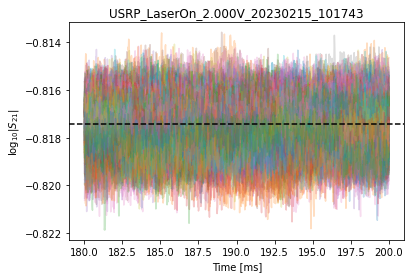

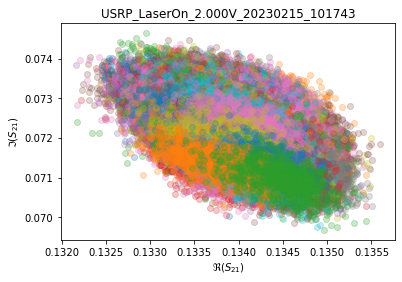

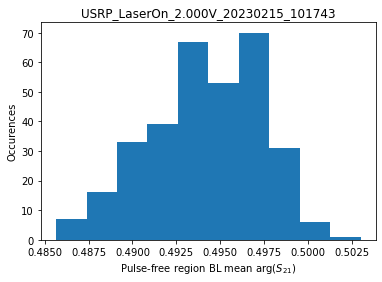

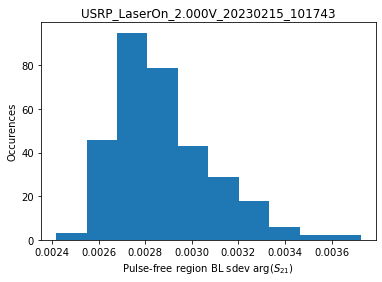

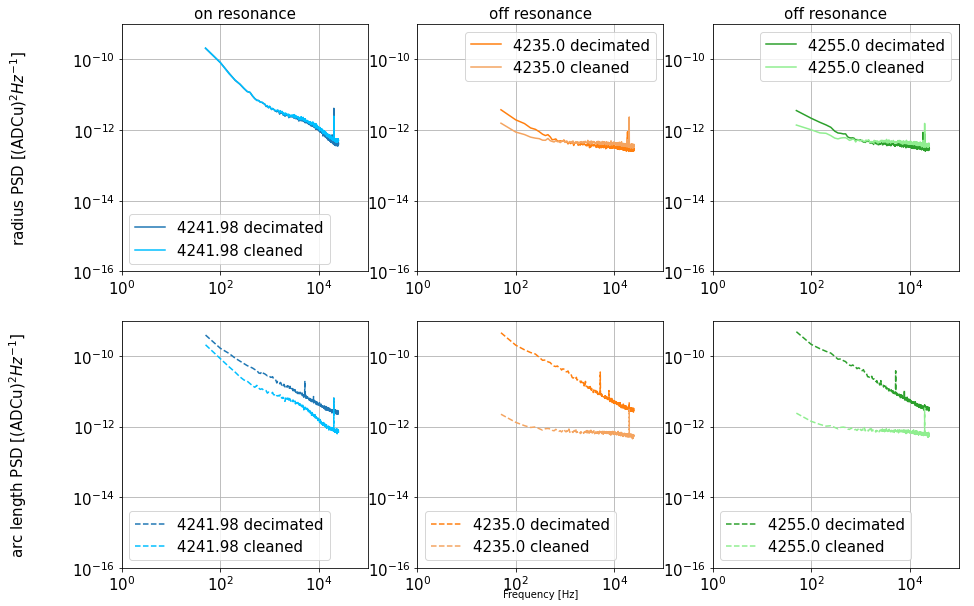

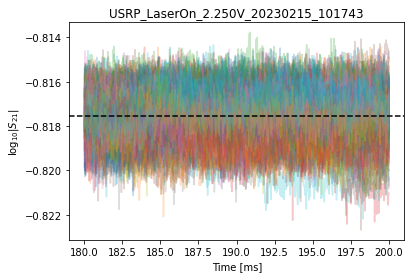

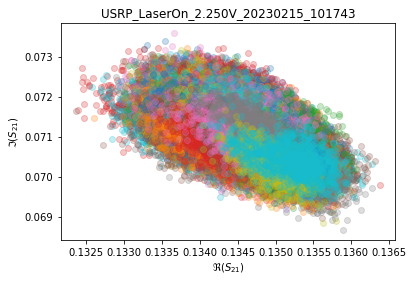

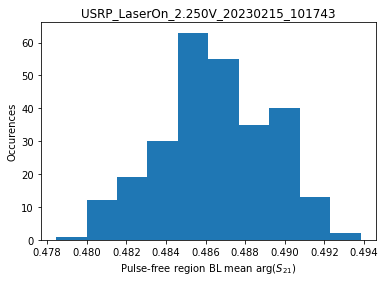

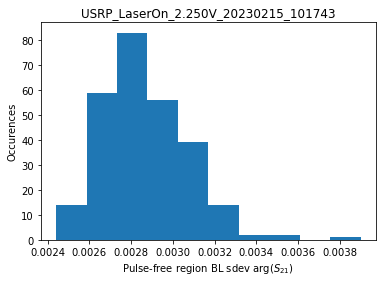

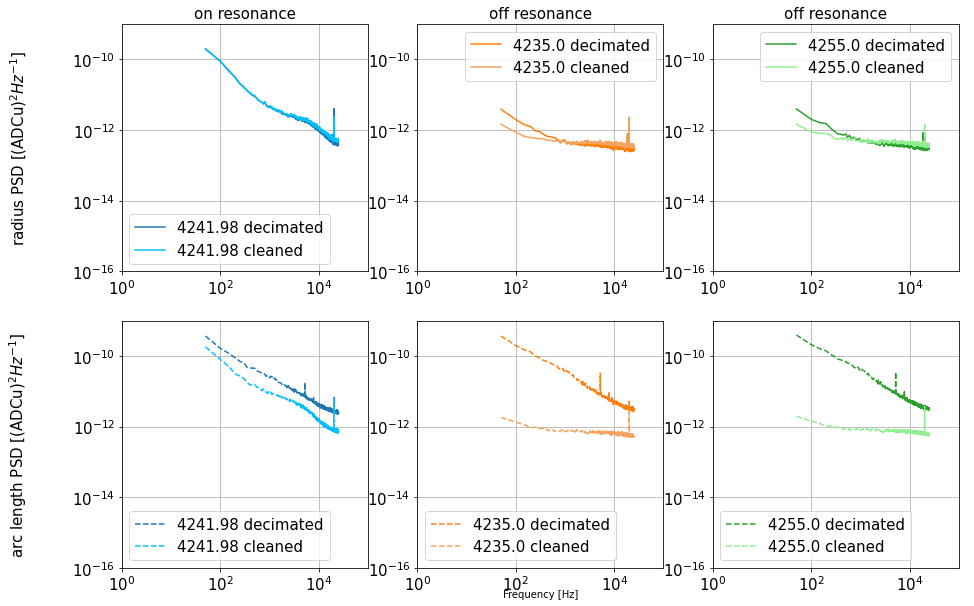

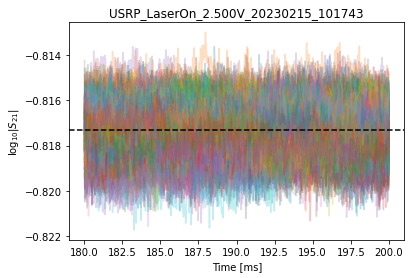

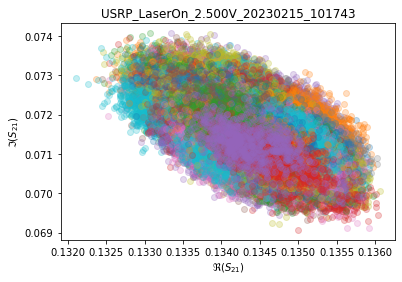

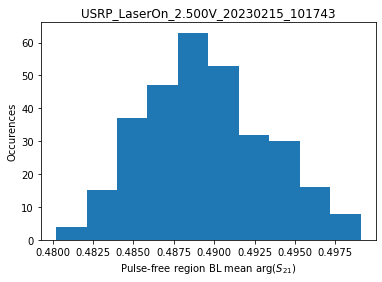

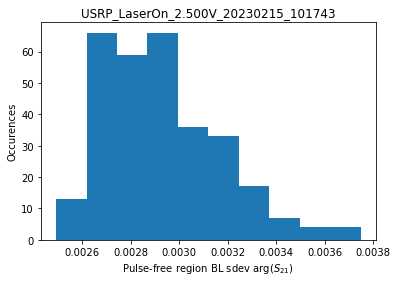

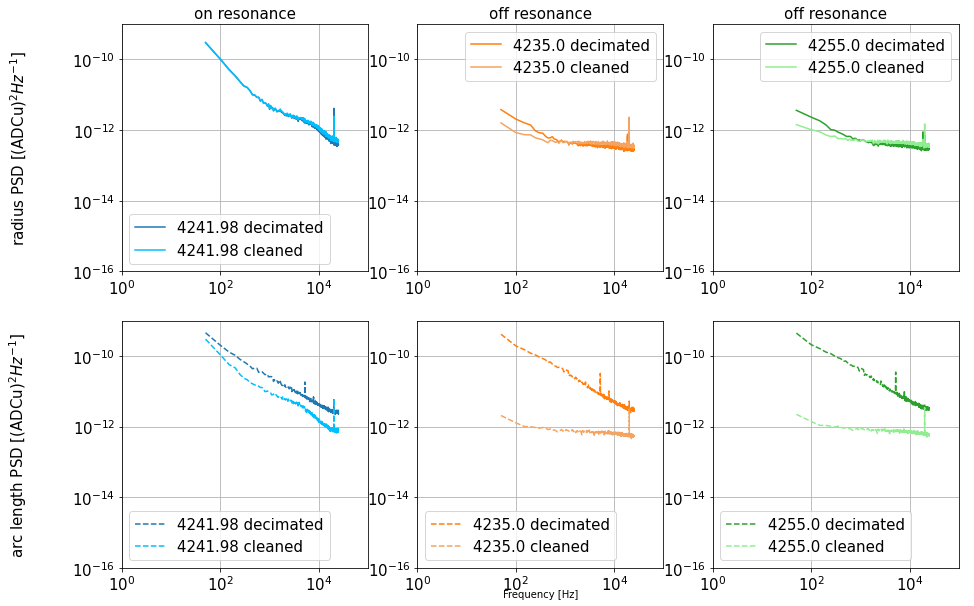

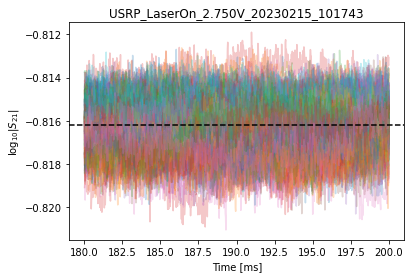

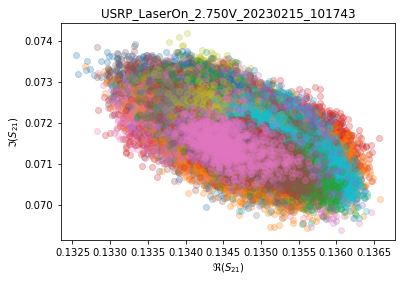

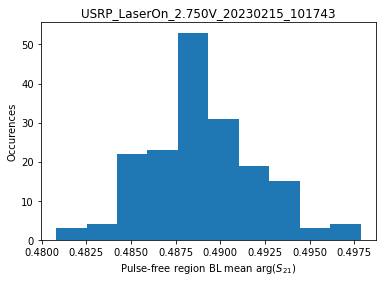

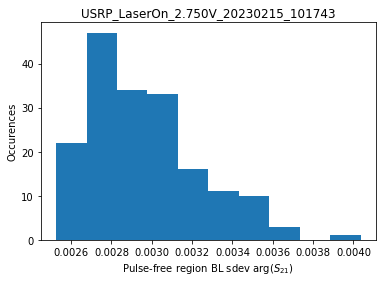

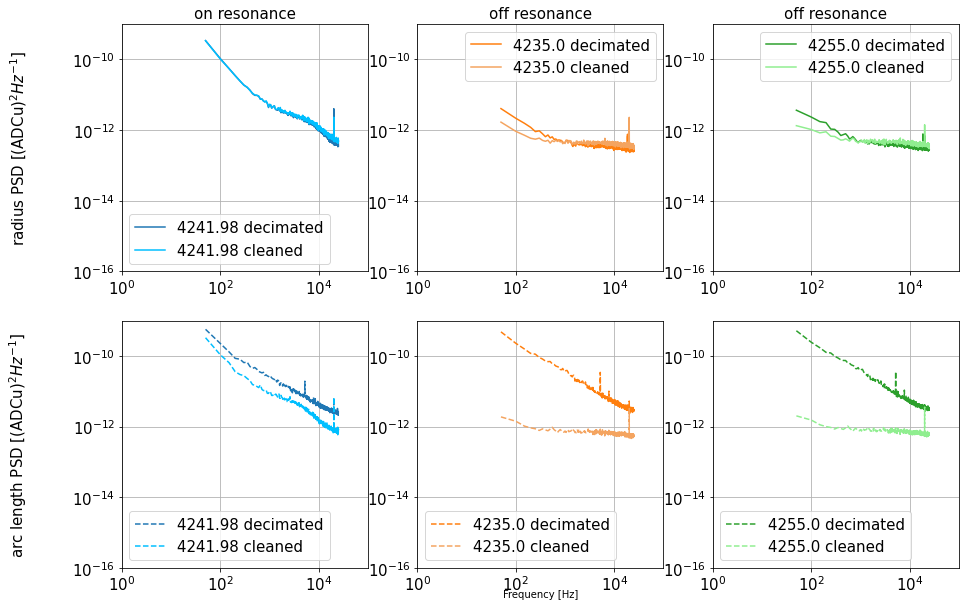

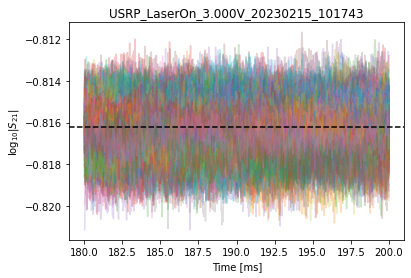

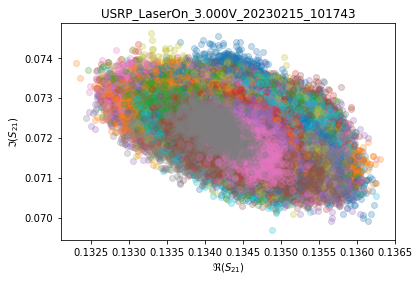

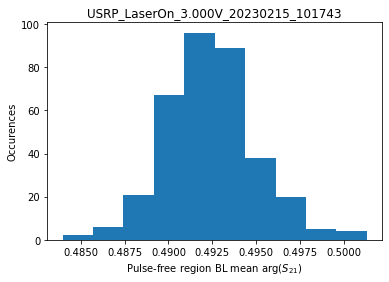

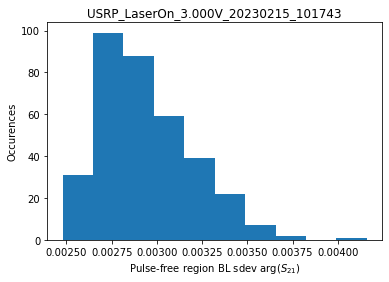

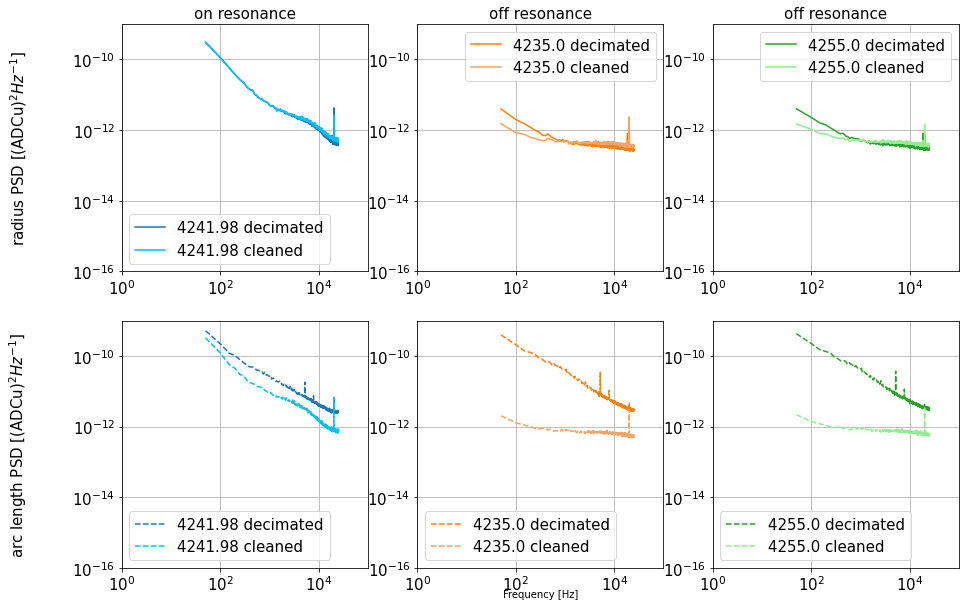

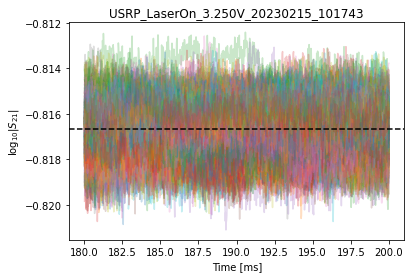

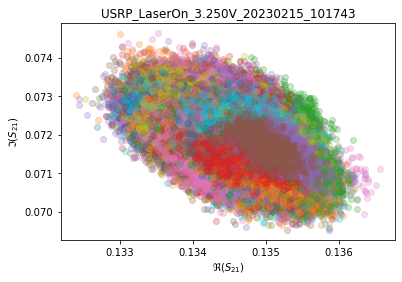

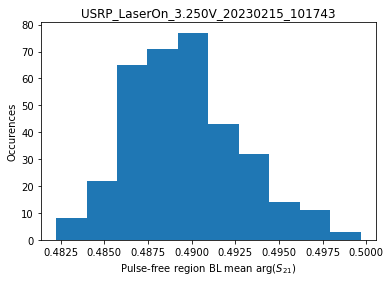

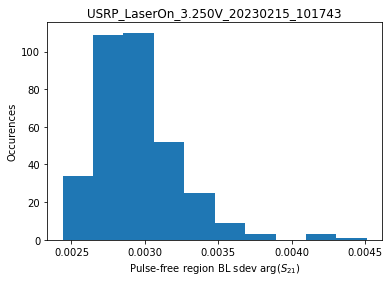

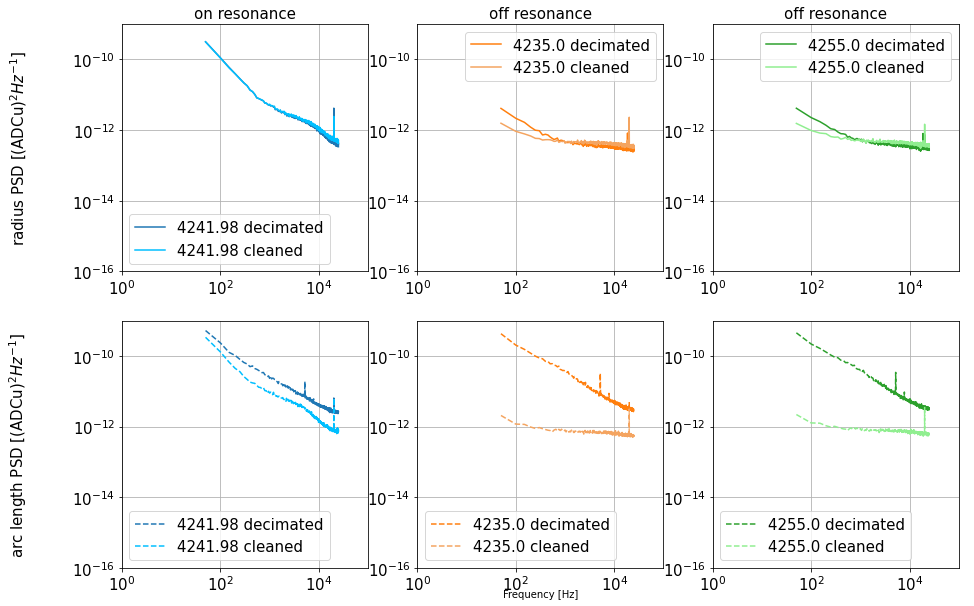

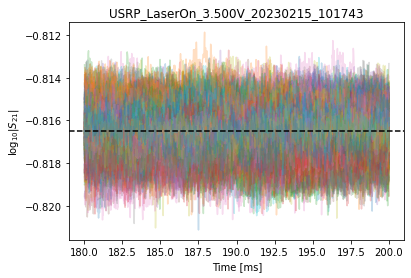

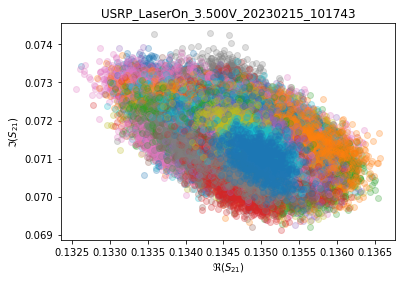

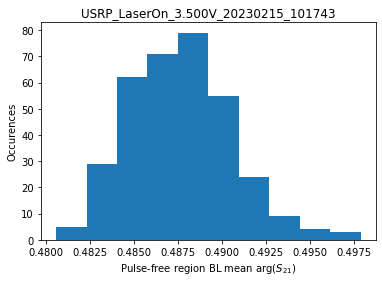

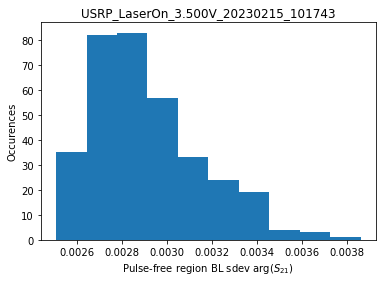

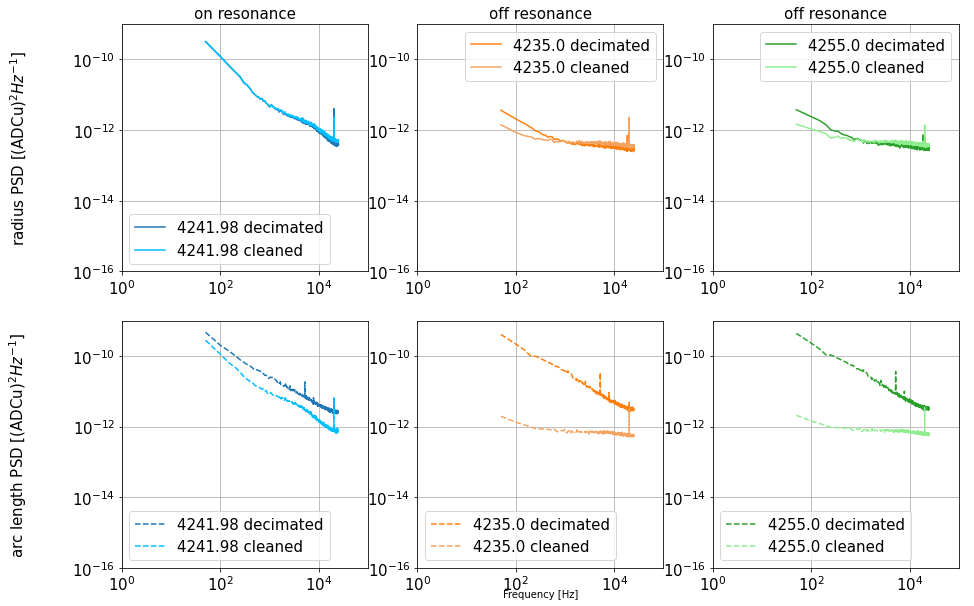

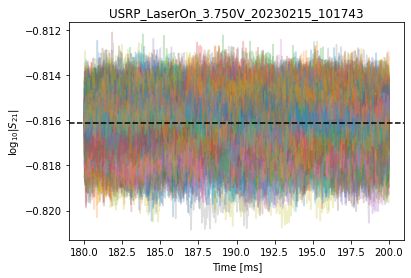

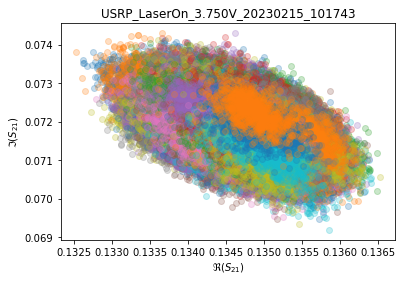

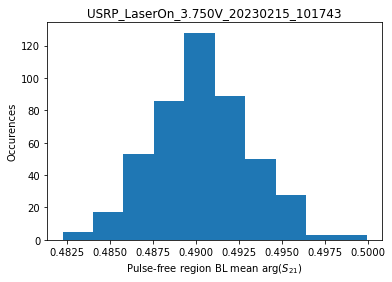

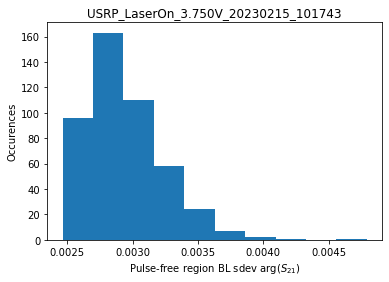

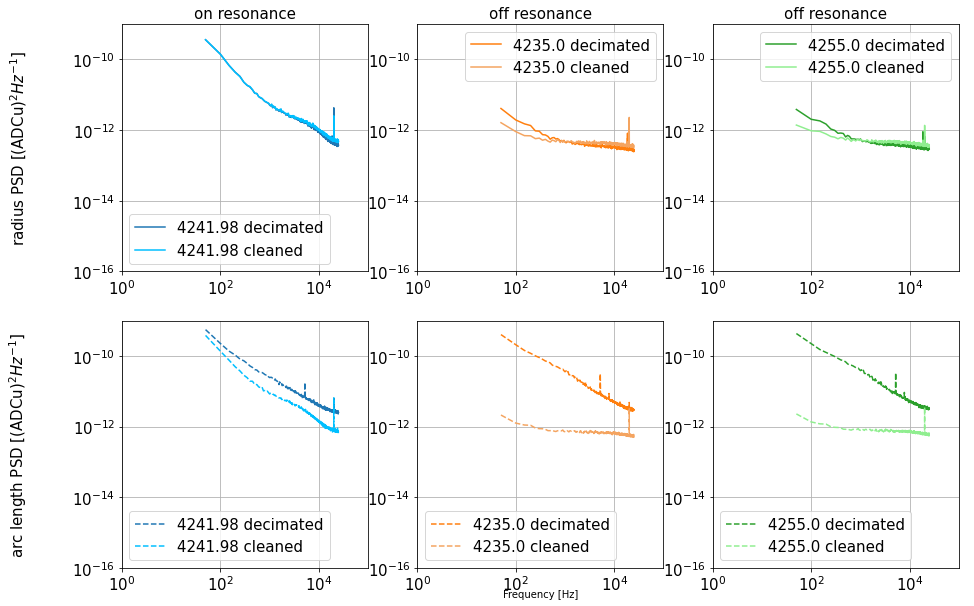

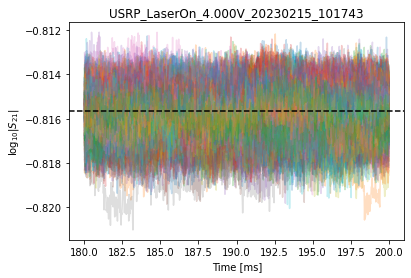

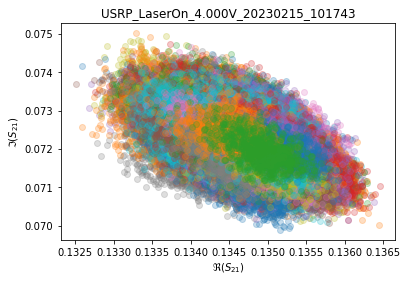

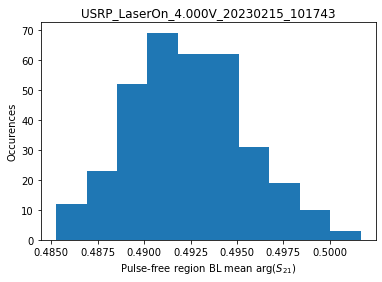

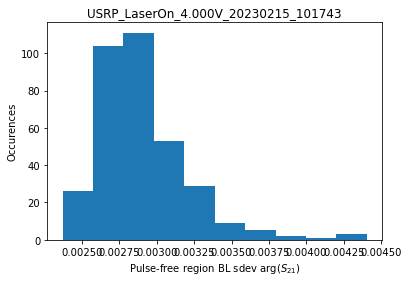

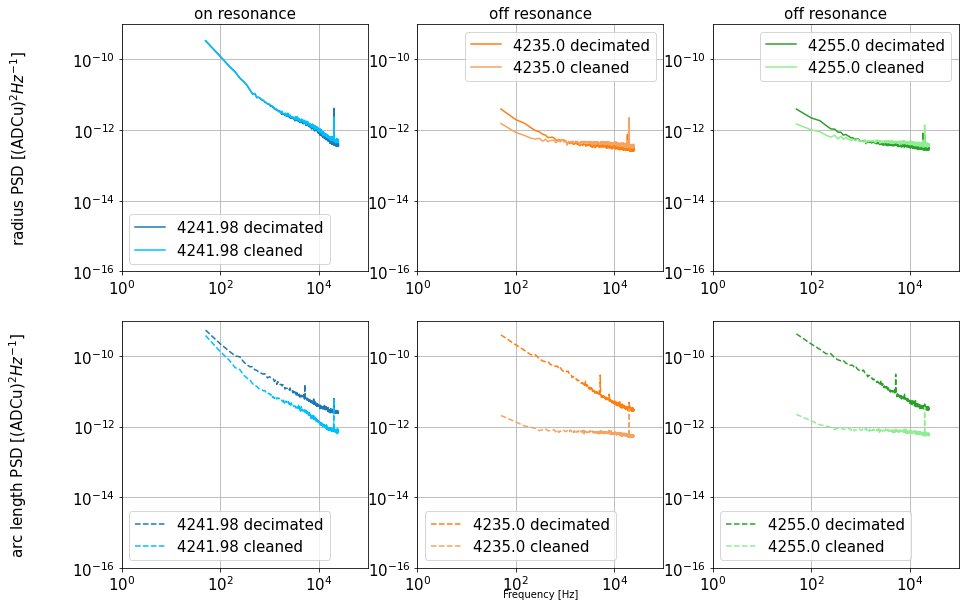

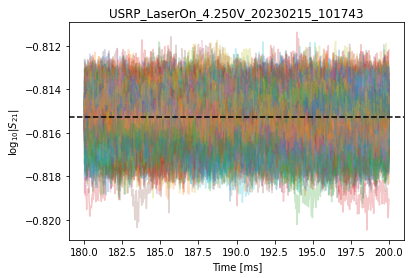

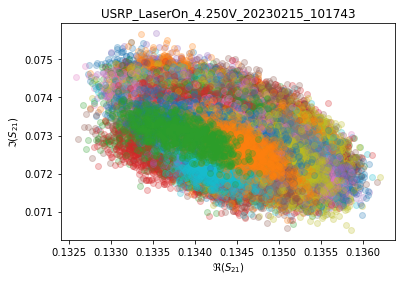

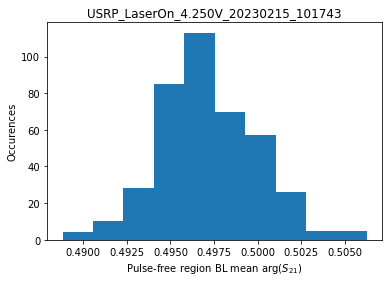

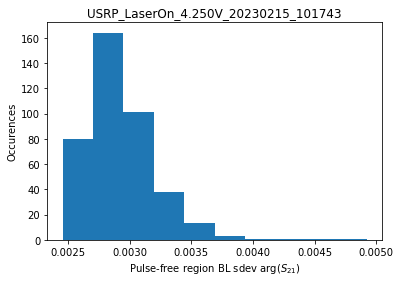

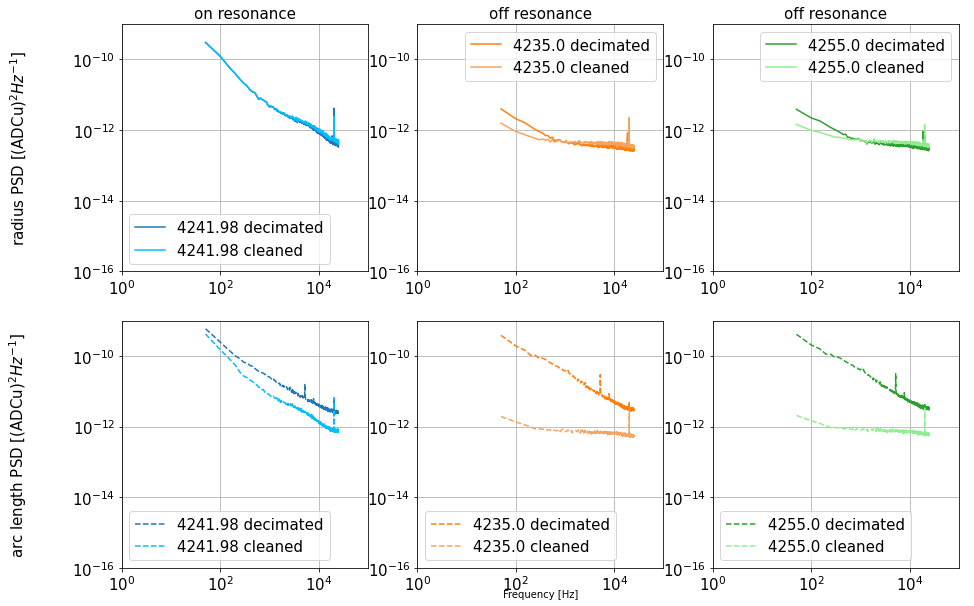

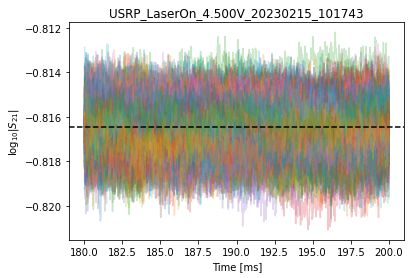

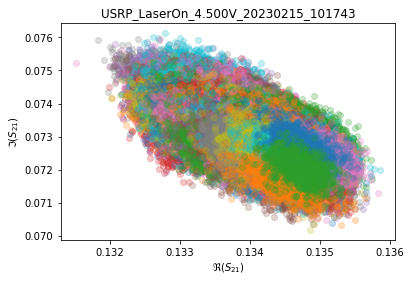

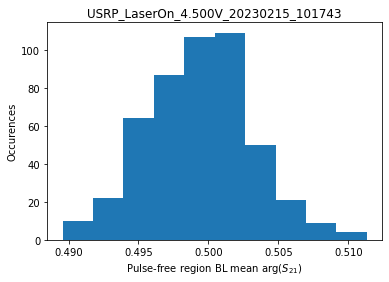

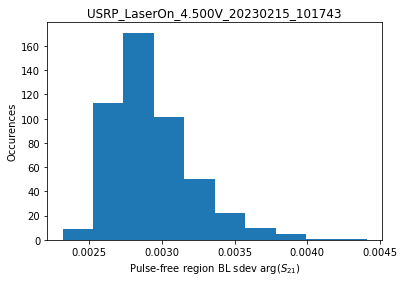

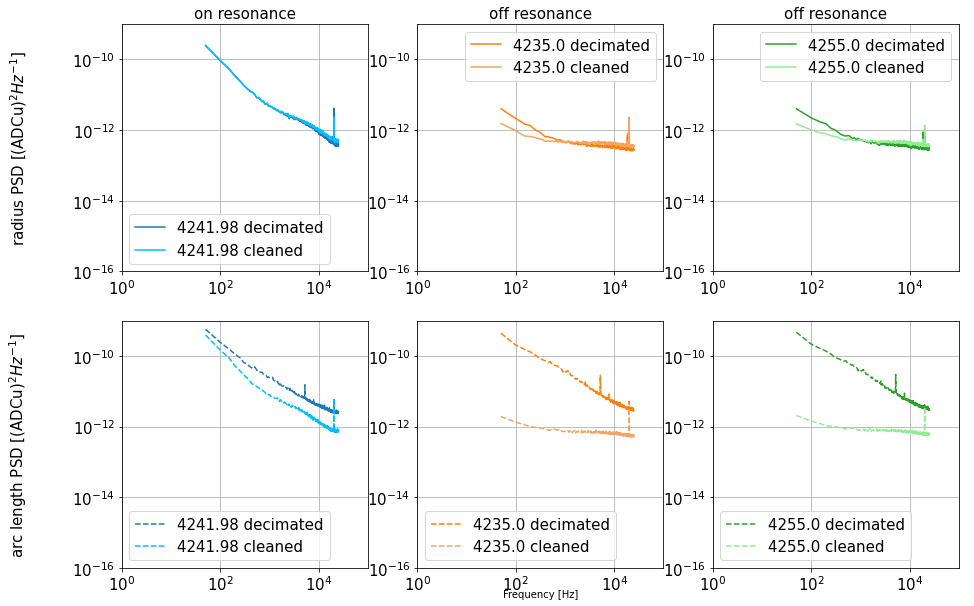

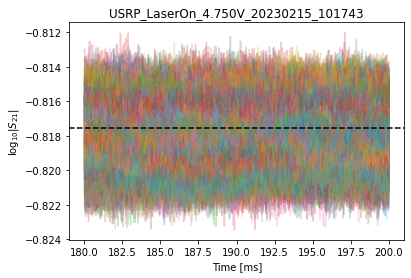

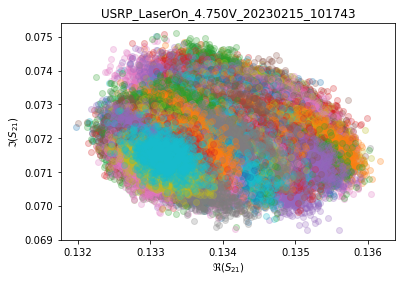

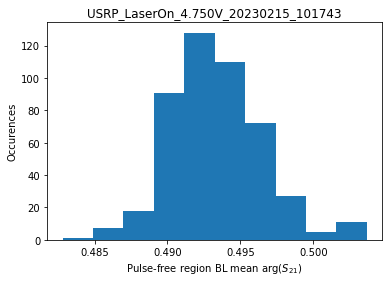

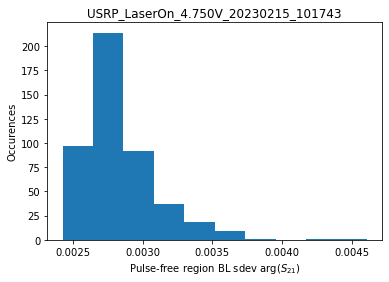

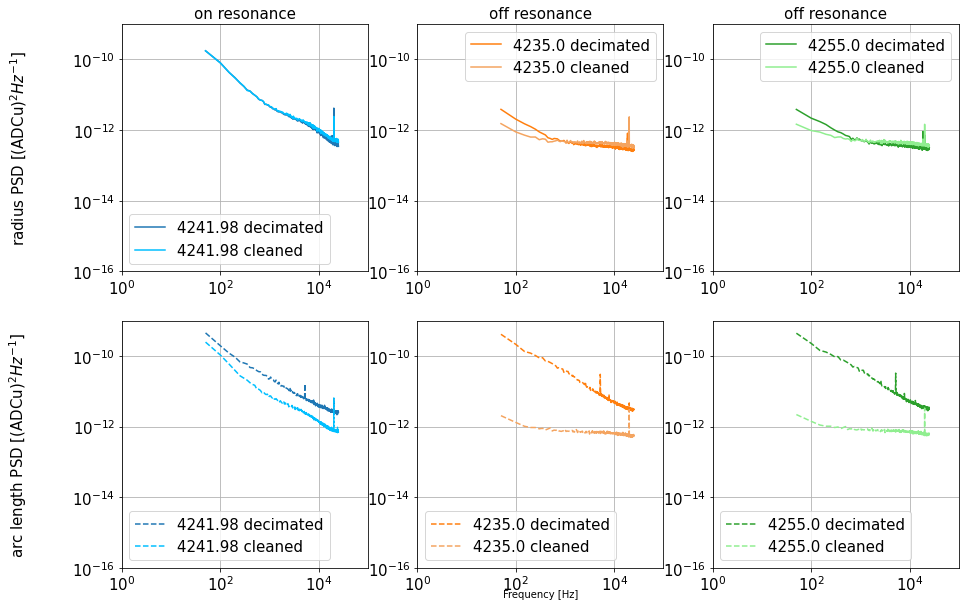

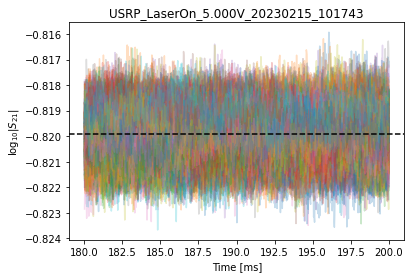

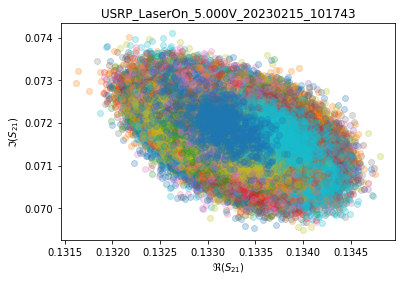

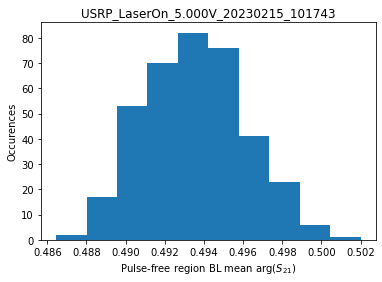

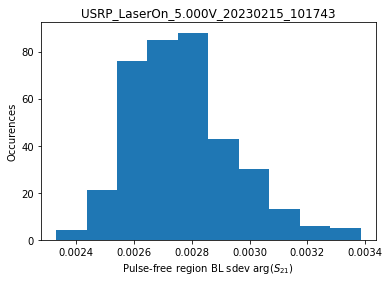

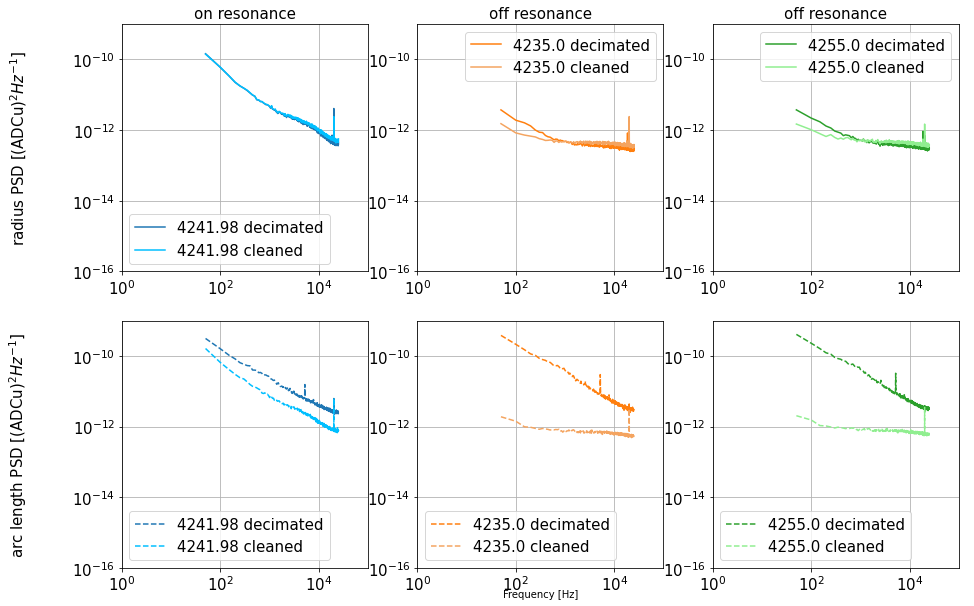

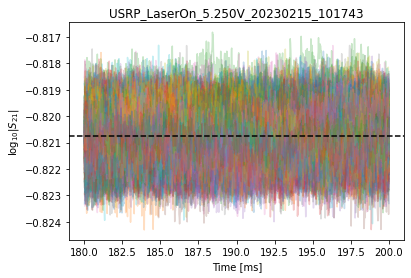

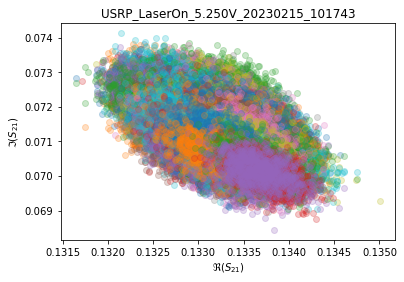

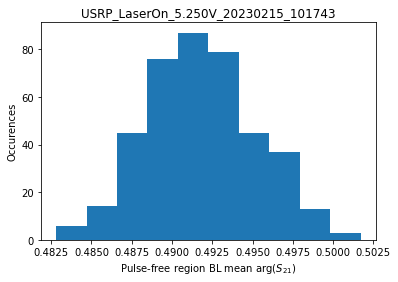

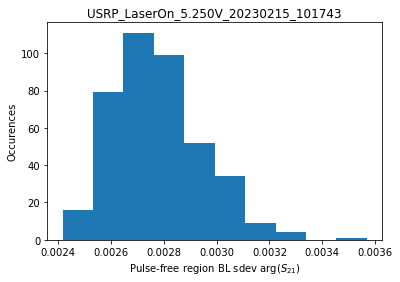

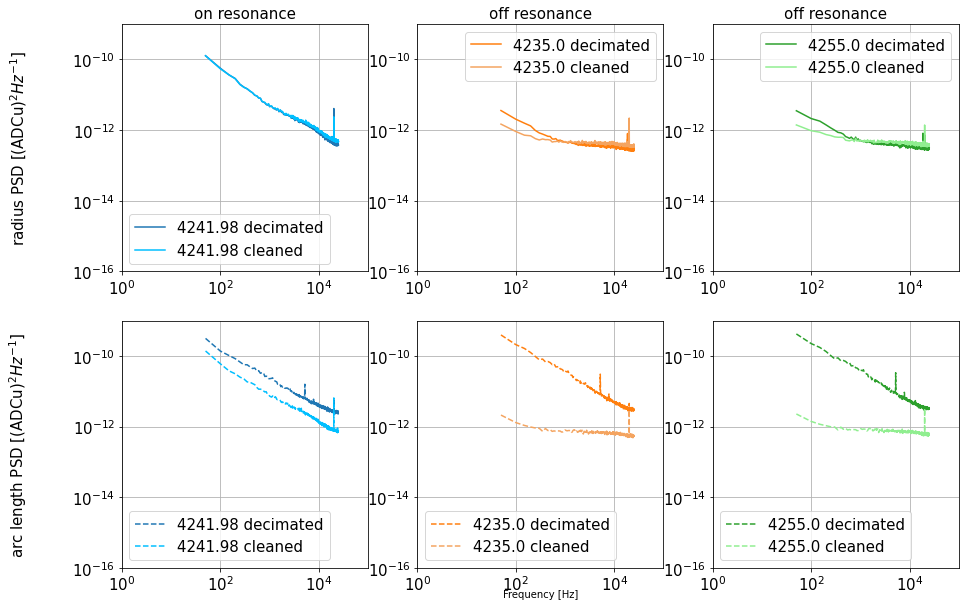

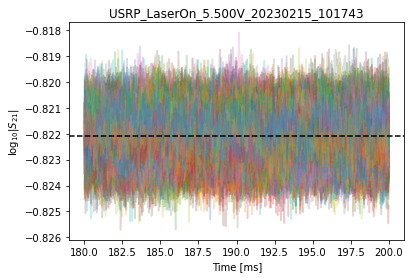

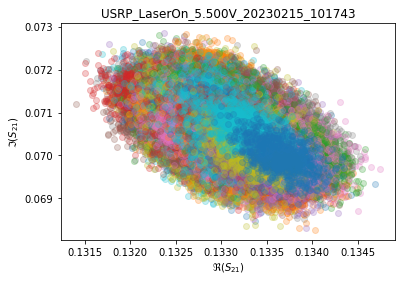

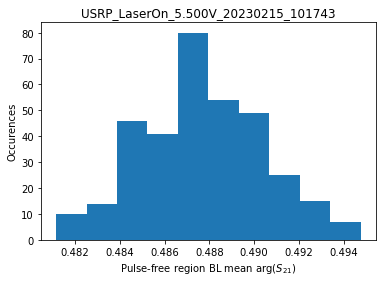

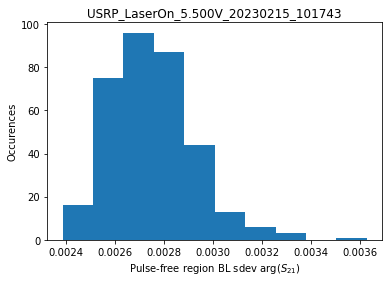

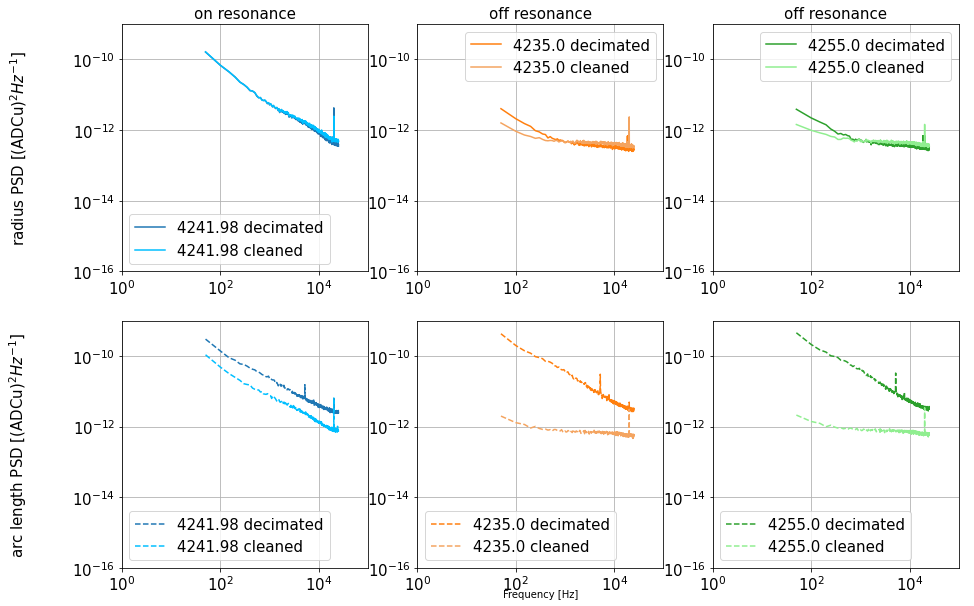

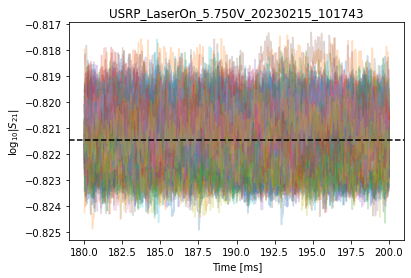

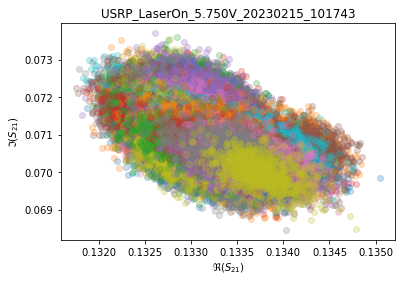

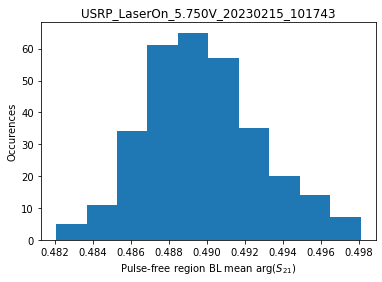

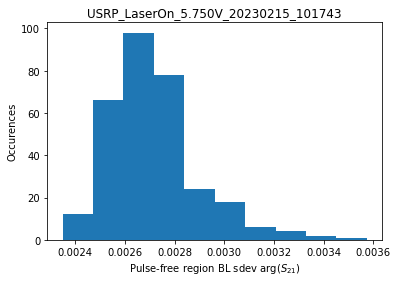

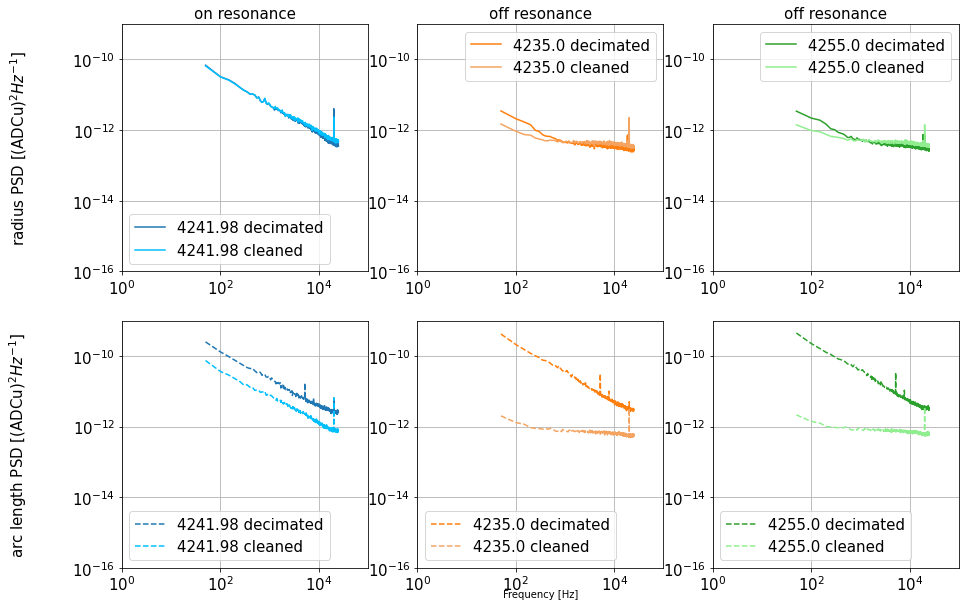

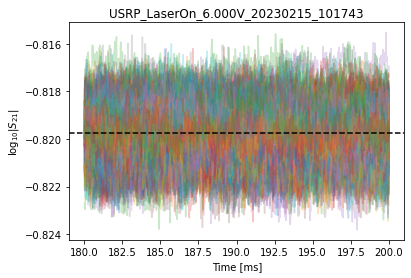

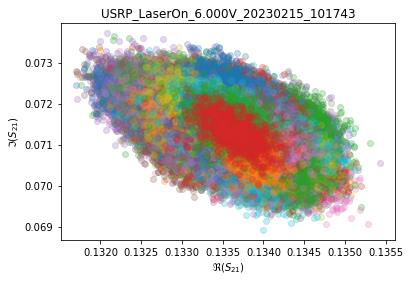

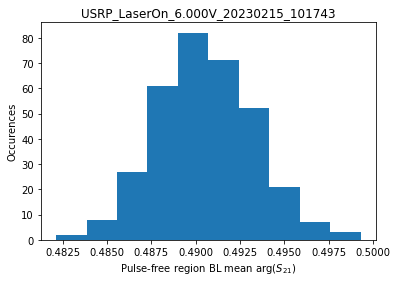

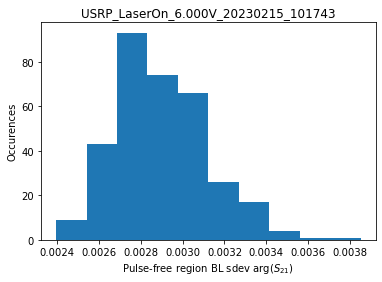

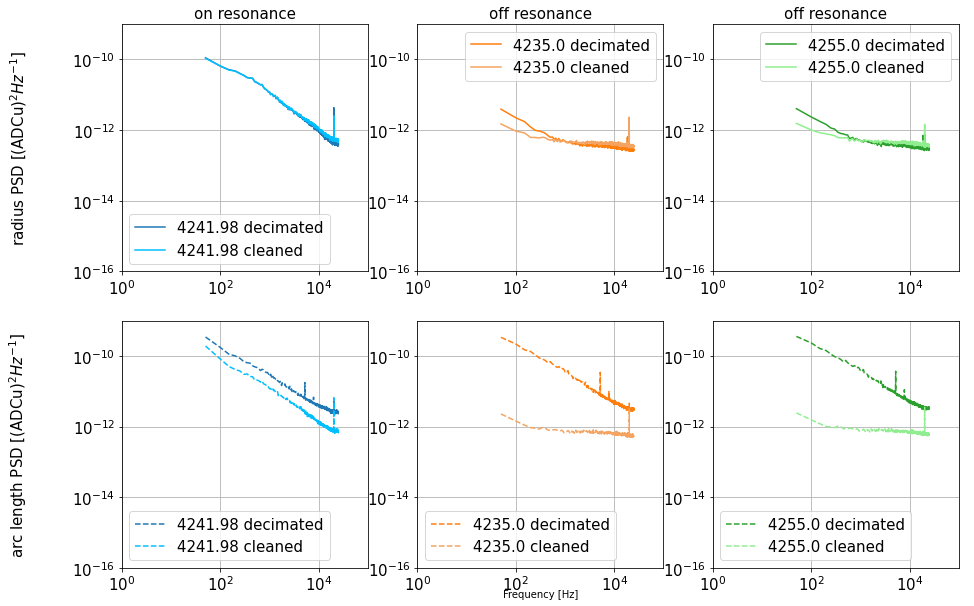

In [14]:
show_plots = True

## Options
verbose = False 

## Window selection for pulse-free region
window_shift_seconds = 0 # -8.0e-3
frac_to_keep = 0.1

## Select the noise file to use
noise_indx = 0
noise_file = nse_files[noise_indx]
    
## We will need these cleaned noise timestreams later
_, _, _, timestreams = Thf.CleanPSDs(noise_file, vna_file, 
    PSD_lo_f=chunk_up_to, 
    PSD_hi_f=decimate_down_to, 
    rem_dec=10,
    f_transient=blank_fraction, 
    charFs=charFs[noise_indx].real, 
    charZs=charZs[noise_indx],show_plots=False, verbose=False)

j = 0
for pulse_file in LED_files:
    print('===================')
    print('cleaning pulse file:',pulse_file)
    print('using VNA file:     ',vna_file)
    print('using noise file:   ',noise_file)

    ## Determine how much additional decimation to apply
    pulse_noise, pulse_info = PUf.unavg_noi(pulse_file)
    pulse_fs = 1./pulse_info['sampling period']
    pulse_cleaning_decimation = int(np.round(pulse_fs/decimate_down_to))

    if verbose:
        print('loaded pulse data')

    ## Get the decimated timestream and frequency step
    pulse_noise = Prf.average_decimate(pulse_noise,pulse_cleaning_decimation)
    pulse_fs   /= pulse_cleaning_decimation

    if verbose:
        print('decimated data by ' + str(pulse_cleaning_decimation) + ' to achieve requested upper bound of ' + '{:2e}'.format(decimate_down_to) + ' Hz' )

    ## Create a new array of of frequency space with the applied decimation
    sampling_rate = pulse_fs
    samples_per_pulse = int(time_btw_pulse*sampling_rate)
    N = int(frac_to_keep * samples_per_pulse) ## We look at the second half of a pulse window only
    T = N/sampling_rate
    t,f = Prf.build_t_and_f(N,sampling_rate)
    time = 1e3*(time_btw_pulse-t[::-1])
    
    if verbose:
        print("Sampling rate:",sampling_rate,"per sec")
        print("Samples per pulse window:",samples_per_pulse)
        print("N=:",N,"; T=",T,";",np.shape(f))
    
    ## Define the regions where pulses exist
    ## =====================================
    
    ## This defines where (in # of pulse windows) to start looking for pulses
    pulse_start = int(total_pulses * blank_fraction)
    if verbose:
        print("Starting pulse partitioning after", pulse_start, "windows (of",total_pulses,")")
    
    ## How many samples to shift the pulse window definition
    window_shift = int(window_shift_seconds * sampling_rate)
    if verbose:
        print("Shifting pulse window by", window_shift, "samples")
    
    ## Create empty arrays to store our results in
    noise_averages = np.zeros((3),dtype=np.complex128)
    J_r = np.zeros((N,3)); J_arc = np.zeros((N,3))
    
    ## Create empty arrays to store values for histograms
    bl_means = np.array([],dtype=np.complex128)
    bl_sdevs = np.array([])#,dtype=np.complex128)
    
    ## Create a plot to store waveforms
    if show_plots:
        fi0 = plt.figure(pulse_file+"_a")
        ax0 = fi0.gca()
        ax0.set_xlabel("Time [ms]")
        ax0.set_ylabel(r"$\log_{10}|S_{21}|$")
        ax0.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
        
        fi1 = plt.figure(pulse_file+"_b")
        ax1 = fi1.gca()
        ax1.set_xlabel(r"$\Re(S_{21})$")
        ax1.set_ylabel(r"$\Im(S_{21})$")
        ax1.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))

    ## Count how many good pulses there are
    n_good_pulses = num_pulses - len(bad_pls_idxs[pulse_file])
    
    ## Start the loop over pulse windows
    k=0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        
        ## Skip the bad pulse windows
        if k in bad_pls_idxs[pulse_file]:
            ## Increment the counter
            k += 1
            continue
        
        ## Define the sample index where this pulse window ends
        pulse_i_end = int((pulse_i+1)*samples_per_pulse)
        
        ## Define the start of the pulse free region (period after pulse, before the next one, where it should be baseline noise)
        no_pulse_idx_start = pulse_i_end + window_shift - N 
        
        ## Define the end of the window (where the pulse-free region ends)
        no_pulse_idx_end   = pulse_i_end + window_shift
        
#         ## Grab the timestreams in the various regions
#         full_pulse_chunk  = pulse_noise[pulse_idx_start:pulse_idx_end,:]
#         pre_trigger_chunk = pulse_noise[pulse_idx_start:pulse_idx_start+pretrig,:]
#         post_pulse_chunk  = pulse_noise[pulse_idx_start+pstpuls:pulse_idx_end,:]
#         peak_pulse_chunk  = pulse_noise[pulse_idx_start+plstrig-peak_area_nsamp:pulse_idx_start+plstrig+peak_area_nsamp]
        
        ## Grab the timestream in that region and average it
        no_pulse_chunk = pulse_noise[no_pulse_idx_start:no_pulse_idx_end,:]
        
        ## Calculate some means and stdevs of this pulse-free timestream
        m = np.mean(no_pulse_chunk,axis=0,dtype=np.complex128) ; bl_means = np.append(bl_means,m[0])
        
        if PHASE:
            s = np.std( np.angle(    no_pulse_chunk[:,0])  ) ; bl_sdevs = np.append(bl_sdevs,s)
        else:
            s = np.std( np.log10(abs(no_pulse_chunk[:,0])) ) ; bl_sdevs = np.append(bl_sdevs,s)
        
        ## Keep a running average of the noise across all pulse regions
        noise_averages += m / n_good_pulses    
        
        ## Plot the pulse free region against time
        if show_plots: # and (k==0):
            ax0.plot(time, np.log10(abs(no_pulse_chunk[:,0])),alpha=0.25)
            ax1.scatter(no_pulse_chunk[:,0].real,no_pulse_chunk[:,0].imag,alpha=0.25)

        ## Convert to the electronics basis and compute the J objects
        r_chunk,arc_chunk,_,_= Prf.electronics_basis(no_pulse_chunk)
        J_r += abs(Prf.discrete_FT(r_chunk))**2 / n_good_pulses * 2 * T
        J_arc += abs(Prf.discrete_FT(arc_chunk))**2 / n_good_pulses * 2 * T
        
        ## Increment the counter
        k += 1
    
    if verbose:
        print("Searched",n_good_pulses,"pulse windows")
        print('used ' + str(n_good_pulses) + ' chunks to find quiescent point')
    
    if show_plots:
        ax0.axhline(y=np.log10(abs(noise_averages[0])),color="k",ls='--')
        
        fi2 = plt.figure(pulse_file+"_c")
        ax2 = fi2.gca()
        if PHASE:
            ax2.hist(np.angle(bl_means))
            ax2.set_xlabel(r"Pulse-free region BL mean $\arg(S_{21})$")
        else:
            ax2.hist(np.log10(abs(bl_means)))
            ax2.set_xlabel(r"Pulse-free region BL mean $\log_{10}(|S_{21}|)$")
        ax2.set_ylabel("Occurences")
        ax2.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
        
        fi3 = plt.figure(pulse_file+"_d")
        ax3 = fi3.gca()
        if PHASE:
            ax3.hist(bl_sdevs)
            ax3.set_xlabel(r"Pulse-free region BL sdev $\arg(S_{21})$")
        else:
            ax3.hist(bl_sdevs)
            ax3.set_xlabel(r"Pulse-free region BL sdev $\log_{10}(|S_{21}|)$")
        ax3.set_ylabel("Occurences")
        ax3.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))

    ## Pull the two real quantities from the complex timestream averages
    radius_averages = abs(noise_averages)
    angle_averages  = np.angle(noise_averages)
    if verbose:
        print(radius_averages)
        print(angle_averages)

    ## Rotate the timestream by the averange angle, then get the rotated phase timestream
    pulse_timestream_rotated = pulse_noise*np.exp(-1j*angle_averages)
    angle_timestream = np.angle(pulse_timestream_rotated)

    ## Subtract off the average magnitude value and calculate an arc length
    radius = abs(pulse_noise) - radius_averages
    arc    = angle_timestream*radius_averages

    ## Create output containers for the clean timestreams
    radius_clean = np.zeros(radius.shape)
    arc_clean    = np.zeros(arc.shape)

    if verbose:
        print('built radius and arc length timestreams given by quiescent point')
        print(noise_file)
        
    ## Pull the dictionary containing cleaning coefficients from the noise timestream
    _,data_info = PUf.clean_noi(noise_file[:-3]+'_cleaned.h5')

    ## Loop over each tone in the radius timestream
    for t in range(radius.shape[1]):
        ## Pull the coefficients from the noise cleaning
        radius_coefficient = data_info['radius cleaning coefficient'][t]
        arc_coefficient    = data_info['arc cleaning coefficient'][t]

        ## Clean each tone with the off-resonance tones
        if t == 0:
            off_tone_idcs = [1,2]
        elif t == 1:
            off_tone_idcs = [2]
        elif t == 2:
            off_tone_idcs = [1]

        ## Perform the radius cleaning
        off_tone_radius = np.mean(radius[:,off_tone_idcs],axis=1,dtype=np.float64)
        radius_clean[:,t] = radius[:,t] - radius_coefficient*off_tone_radius

        ## Perform the arc length cleaning
        off_tone_arc = np.mean(arc[:,off_tone_idcs],axis=1,dtype=np.float64)
        arc_clean[:,t] = arc[:,t] - arc_coefficient*off_tone_arc

        if verbose: 
            print('cleaned tone ' + str(t))

    ## Subtract off the mean from cleaned radius and arc length timestreams
    radius_clean -= np.mean(radius_clean,axis=0,dtype='float64')
    arc_clean -= np.mean(arc_clean,axis=0,dtype='float64')
    
    ## Save the clean timestreams to a file
    pulse_noise_clean = Prf.save_clean_timestreams(pulse_file,\
                                                   radius_averages,\
                                                   angle_averages,\
                                                   radius_clean,\
                                                   arc_clean,\
                                                   sampling_rate,\
                                                   timestreams['radius coefficient'],\
                                                   timestreams['arc coefficient'],\
                                                   override=True)

    ## Calculate the PSDs for each of the cleaned pulses
    
    ## Create containers for our output PSDs
    J_r_clean = np.zeros((N,3)); J_arc_clean = np.zeros((N,3))
    
    ## Loop over pulses
    k = 0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        ## Skip the bad pulse windows
        if k in bad_pls_idxs[pulse_file]:
            ## Increment the counter
            k += 1
            continue
        
        ## Define the sample index where this pulse window ends
        pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
        
        ## Define the start of the pulse free region (period after pulse, before the next one, where it should be baseline noise)
        no_pulse_idx_start = pulse_i_end + window_shift - N 
        
        ## Define the end of the window (where the pulse-free region ends)
        no_pulse_idx_end   = pulse_i_end + window_shift
        
        ## Grab the timestream in that region
        no_pulse_chunk = pulse_noise_clean[no_pulse_idx_start:no_pulse_idx_end,:]

        ## Convert the pulse-free region to electronics basis
        r_chunk,arc_chunk,_,_= Prf.electronics_basis(no_pulse_chunk)
        
        ## Compute the PSDs
        J_r_clean += abs(Prf.discrete_FT(r_chunk))**2 / n_good_pulses * 2 * T
        J_arc_clean += abs(Prf.discrete_FT(arc_chunk))**2 / n_good_pulses * 2 * T
        
        ## Increment the counter
        k += 1

    ## Trim the output to the positive frequency region only
    J_r = J_r[f>=0]; J_r_clean = J_r_clean[f>=0]; J_arc = J_arc[f>=0]; J_arc_clean = J_arc_clean[f>=0]
    
    ## Every tenth files, show the PSDs
    if j % 1 == 0:
        print(pulse_file)
        fig_0, axes_0 = plt.subplots(2,3,sharex=True,sharey='row',figsize=(5*3,10))
        
        Prf.plot_PSDs(f[f>0],J_r,J_arc,pulse_file,\
                      ['radius','arc length'],units=['ADCu','ADCu'],savefig='electronics',\
                      data_freqs=pulse_info['search freqs'],\
                      P_1_clean=J_r_clean,P_2_clean=J_arc_clean,\
                      fig_0=fig_0,axes_0=axes_0)

    j += 1